# LSTM for new type of datasets

In [301]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn

import pandas as pd
import numpy as np

import plotly.express as px
from torch.optim import Adam
from torch.optim import SGD


import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

## Classes

In [302]:
# class SequentDataset(Dataset):
#     def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=4):
#         self.n_dot_parameters = n_dot_parameters
#         self.n_dots = n_dots
#         self.X_, self.y_ = self.__make_stack(dataframe)
#         # print(self.X_.shape)
#         # print(self.y_.shape)

#     def __len__(self):
#         return len(self.X_)

#     def __getitem__(self, idx):
#         return self.X_[idx], self.y_[idx]

#     def __make_stack(self, df: pd.DataFrame):
#         seq_amount = df.shape[0] - 2 * self.n_dots - 1
#         X = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
#         y = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
#         for i in range(seq_amount):
#             X[i, :, :] = torch.reshape(torch.tensor(df.values[i:i+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
#             y[i, :, :] = torch.reshape(torch.tensor(df.values[i+1:i+1+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))

#         # stacks = [[df.iloc[:-self.n_dots]]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
#         return (X, y)

In [303]:
# sts
class SequentDataset(Dataset):
    def __init__(self, dataframe: pd.DataFrame, n_dots=1, n_dot_parameters=7):
        self.n_dot_parameters = n_dot_parameters
        self.n_dots = n_dots
        self.X_, self.y_ = self.__make_stack(dataframe)
        # print(self.X_.shape)
        # print(self.y_.shape)

    def __len__(self):
        return len(self.X_)

    def __getitem__(self, idx):
        return self.X_[idx], self.y_[idx]

    def __make_stack(self, df: pd.DataFrame):
        seq_amount = df.shape[0] - 2 * self.n_dots - 1
        X = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        y = torch.zeros((seq_amount, self.n_dots, self.n_dot_parameters), dtype=torch.float32)
        for i in range(seq_amount):  
            X[i, :, :] = torch.reshape(torch.tensor(df.values[i:i+self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
            y[i, :, :] = torch.reshape(torch.tensor(df.values[i+self.n_dots : i+2*self.n_dots, :], dtype=torch.float32), (1, self.n_dots, self.n_dot_parameters))
            

        # stacks = [[df.iloc[:-self.n_dots]]] + [df.iloc[i:].values if (self.n_dots == i) else df.iloc[i:-(self.n_dots - i)].values for i in range(1, self.n_dots + 1)]
        return (X, y)

In [304]:
class LSTMModel(nn.Module):
    def __init__(self, input_size=7, hidden_layer_size=100, output_size=7, num_layers=10):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size
        self.num_layers = num_layers

        # Define the LSTM layer
        # self.linear0 = nn.Linear(hidden_layer_size, hidden_layer_size)

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers, batch_first=True)

        # Define the output layer
        self.linear = nn.Linear(hidden_layer_size, output_size)

    def forward(self, x):
        # x = x.to(device)
        batch_size = x.size(0)
        self.h = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        # self.h = self.h.to(device)
        self.c = torch.zeros(self.num_layers, batch_size, self.hidden_layer_size).requires_grad_()
        # self.c = self.c.to(device)
        out, _ = self.lstm(x, (self.h, self.c))

        # print(out.size())

        # Pass through fully connected layer
        out = self.linear(out)  # We want the output corresponding to the last time step
        return out

In [305]:
N_DOTS = 25
BATCH_SIZE = 8
N_DOT_PARAMETERS = 7
N_LSTM_LAYERS = 1

In [306]:
trajectory_train = pd.read_csv("../../sets_for_article/parab_train.csv")
trajectory_test = pd.read_csv("../../sets_for_article/parab_test.csv")

trajectory_train['t'] = 1
trajectory_test['t'] = 1

std = StandardScaler()
trajectory_train = std.fit_transform(trajectory_train)
trajectory_train = pd.DataFrame(trajectory_train, columns=["t", "X", "Y", "Z", "Vx", "Vy", "Vz", "I"])

In [307]:
trajectory_train

,t,X,Y,Z,Vx,Vy,Vz,I
0,0.0,2.296479,2.772670,-1.915188,-0.000106,-12.051327,1.708646,0.0
1,0.0,2.295797,2.771588,-1.914757,0.779600,-0.614244,-1.534304,0.0
2,0.0,2.295069,2.770290,-1.914292,0.305005,0.208922,-1.767368,0.0
3,0.0,2.294329,2.768545,-1.913805,-1.248798,0.561490,-1.866959,0.0
4,0.0,2.293535,2.767015,-1.913294,-0.079987,1.368996,-2.095467,0.0
...,...,...,...,...,...,...,...,...
9995,0.0,-1.024265,1.226188,1.535183,0.897238,1.197370,1.706937,0.0
9996,0.0,-1.024214,1.227072,1.535411,-0.509161,-0.328137,1.707478,0.0
9997,0.0,-1.024160,1.228234,1.535665,0.047040,1.186081,1.707716,0.0
9998,0.0,-1.024114,1.229306,1.535886,0.258920,-0.490304,1.708171,0.0


In [308]:
fig = px.line_3d(trajectory_train, x="X", y="Y", z="Z", color='I')
fig.show()

In [309]:
train = SequentDataset(trajectory_train[['t','X','Y','Z','Vx','Vy','Vz']][:8000], N_DOTS, 7)
test = SequentDataset(trajectory_train[['t','X','Y','Z','Vx','Vy','Vz']][8000:], N_DOTS, 7)
test2 = SequentDataset(trajectory_test[['t','X','Y','Z','Vx','Vy','Vz']], N_DOTS, 7)

In [310]:
model = LSTMModel(input_size=N_DOT_PARAMETERS, num_layers=N_LSTM_LAYERS, hidden_layer_size=N_DOTS,output_size=N_DOT_PARAMETERS)
# loss_model = nn.L1Loss()
loss_model = nn.HuberLoss()
# loss_model = nn.MSELoss()
# opt = Adam(model.parameters(), lr=0.005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=5, gamma=0.5)

In [311]:
# opt = Adam(model.parameters(), lr=0.0005)
opt = SGD(model.parameters(), lr=0.05)
lr_scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.5)

In [312]:
# model.load_state_dict(torch.load("lstm_dach_31_10.pt"))

In [ ]:
def train_model(model, criterion, optimizer, train_loader, device):
    model.train()
    train_loss = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        train_loss.append(loss.item())

        loss.backward()
        optimizer.step()
    
    return sum(train_loss)/len(train_loss)

In [314]:
def evaluate_model(model, criterion, test_loader, device):
    model.eval()
    val_loss = []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss.append(loss.item())
    return sum(val_loss)/len(val_loss)

In [315]:
EPOCH = 50
train_losses = []
val_losses = []

train_data, val_data = random_split(train,[0.8,0.2])

train_loader = DataLoader(train_data, batch_size=8, shuffle=False)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)

for epoch in range(EPOCH):

    mean_train_loss = train_model(model, loss_model, opt, train_loader, "cpu")

    train_losses.append(mean_train_loss)

    mean_val_loss = evaluate_model(model, loss_model, val_loader, "cpu")

    val_losses.append(mean_val_loss)

    lr_scheduler.step()
    lr = lr_scheduler.get_last_lr()

    print(f"Epoch [{epoch+1}/{EPOCH}], train_loss = {mean_train_loss:.6f}, val_loss = {mean_val_loss:.6f}, lr = {lr}")

torch.Size([8, 25, 7])


ZeroDivisionError: division by zero

In [ ]:
model.h.shape

torch.Size([1, 1, 25])

In [ ]:
# torch.save(model.state_dict(),"lstm_dach_31_10.pt")

In [ ]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

<function matplotlib.pyplot.show(close=None, block=None)>

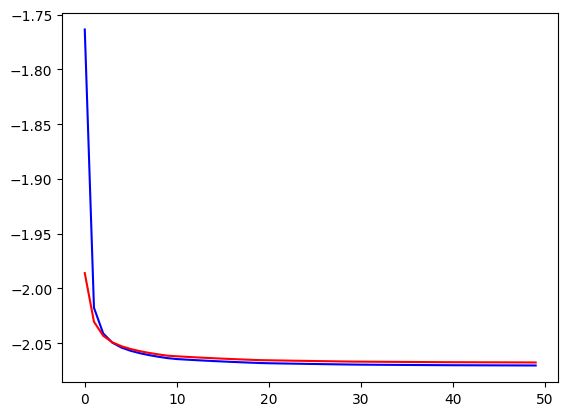

In [ ]:
plt.plot(np.log(train_losses), '-b')
plt.plot(np.log(val_losses), '-r')
plt.show

In [ ]:
# predictions = []
# true = []

# start, _ = test[0]
# start = torch.reshape(start, (1,N_DOTS,N_DOT_PARAMETERS))

# for i in range(1000):
#     with torch.no_grad():
#         pred = model(start)
#         predictions.append(pred[0, -1, :])
#         start[0, :-1, :] = start.clone()[0, 1:, :]
#         start[0, -1, :] = pred[0, -1, :]
#         # start = pred
# _, y_true  = test[:1000]
# _, last = train[:]

In [ ]:
# sts
predictions = []
true = []

start, _ = test[0]
start = torch.reshape(start, (1,N_DOTS,N_DOT_PARAMETERS))
print(start.shape)
for i in range(1000):
    with torch.no_grad():
        pred = model(start)
        predictions.append(pred[0, -1, :])
        start = pred
        # start = pred
_, y_true  = test[:1000]
_, last = train[:]

torch.Size([1, 25, 7])


In [ ]:
pred_data = pd.DataFrame([[0,0,0,0,0,0,0,0]], columns=["Time", "X", "Y", "Z", "Vx", "Vy", "Vz", "I"])

p_x = pd.DataFrame(np.vstack(list(map(lambda x: x.detach().numpy(), predictions))), columns=["Time", "X", "Y", "Z", "Vx", "Vy", "Vz"])
p_x['I'] = "Predict"
_, y  = test[:]
p_y = pd.DataFrame(y.detach().numpy()[:, 0, :], columns=["Time", "X", "Y", "Z", "Vx", "Vy", "Vz"])
p_y['I'] = "True"
p_last = pd.DataFrame(last.detach().numpy()[:, 0, :], columns=["Time", "X", "Y", "Z", "Vx", "Vy", "Vz"])
p_last["I"] = "Last"

# std.inverse_transform(p_x)
# std.inverse_transform(p_y)
# std.inverse_transform(p_last)

pred_data = pd.concat([pred_data,p_x,p_y,p_last],axis=0)


aaaab = pred_data.drop(pred_data.index[0], inplace=False)


In [ ]:
fig = px.line_3d(aaaab, x="X", y="Y", z="Z", color='I',markers=0)
fig.show()